### 1D Bar Problem With Variable Loading

#### Importing all the necessary packages

In [1]:
using Flux
using Statistics
using Plots
using LinearAlgebra
using CPUTime

##### Problem to be solved

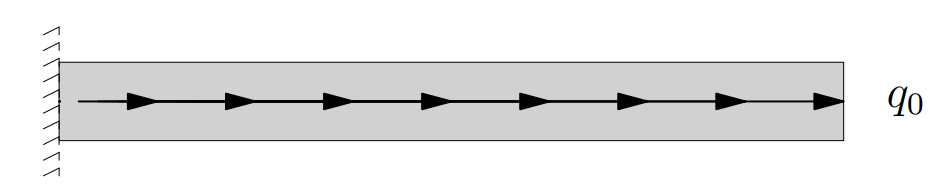


$$
\frac{d(\delta)}{dx} = \frac{q_0 (L-x)}{A E} \\
\delta (0.0) = 0.0 \space [Boundary \space Condition]\\
length(L) = 5m \\
Area(A) = 0.04m^2 \\
$$

### Input parameters

In [2]:
A = 0.04 #m2
L = 5 #m
E = 200 * 10^6 #kN/m2
q = 1.5 #kN/m
dx = 0.1 #discritization

# Neural Network parameters
dim = 1
N = 32 # Number of nodes in the hidden layer

32

##### This model is for tension

Chain function is used to create the collection of different layers. In the below Neural Network there is one hidden dense layer, which contain N nodes each.

In [3]:
δ = Chain(x -> [x], Dense(dim,N,tanh),Dense(N,dim), x -> x[1])

Chain(
  var"#1#3"(),
  Dense(1, 32, tanh),                   # 64 parameters
  Dense(32, 1),                         # 33 parameters
  var"#2#4"(),
)                   # Total: 4 arrays, 97 parameters, 644 bytes.

Activation Function "tanh" : - 
Activation functions are used to provide non-linearity in the model. There are several activation functions such as 'ReLU', 'LeakyReLU', 'sigmoid' and 'tan-h'(hyperbolic tangent activation function) etc. the reason behind tanh is that it's range is in between [-1, 1] which provides more better results as compared to the sigmoid activation function.

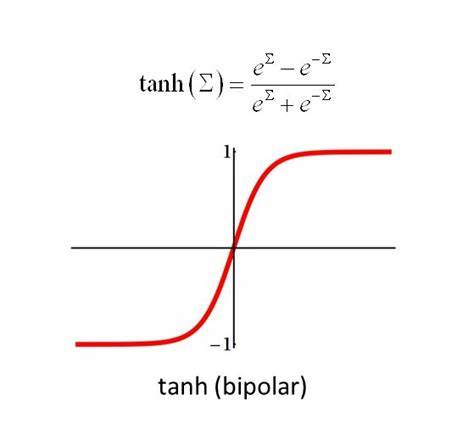

### Function to define the governing equation

In [4]:
ϵ = sqrt(eps(Float32))

function ODE(x)
    return ((δ.(x .+ ϵ) .- δ.(x)) ./ϵ) .- (L .- x)
end

ODE (generic function with 1 method)

### Discretization 

In [5]:
dom = collect(0.0:dx:L)
z1 = 0

0

### Define Loss function

Satisfying boundary conditions and the governing equation at discretized points.

In [6]:
loss1() = norm((abs2.(ODE(dom))) .+ abs2.(δ.(z1)))

loss1 (generic function with 1 method)

### Define Neural network parameters (ps1) and optimizers to train the model

In [7]:
ps1 = Flux.params(δ)
opt1 = Flux.ADAM(0.03)                          
data1 = Iterators.repeated((),5500)

Base.Iterators.Take{Base.Iterators.Repeated{Tuple{}}}(Base.Iterators.Repeated{Tuple{}}(()), 5500)

#### Define function to train the model

In [8]:
function my_custom_train!(loss, ps, data, opt)
    local training_loss
    itr = 0
    for d in data
        gs = gradient(ps) do
            training_loss = loss()
            if (itr %500 == 0.0)
                print("Current Loss : ",training_loss,"\n")
            end
            return training_loss
        end
        Flux.Optimise.update!(opt, ps, gs)
        itr += 1;
    end
end

my_custom_train! (generic function with 1 method)

#### Train the model

In [9]:
# sleep(10) it can be used to give a pause of 10 sec in the process,
# we can provide the elepsed time accoarding to our convenience
@time @CPUtime my_custom_train!(loss1, ps1, data1, opt1)

Current Loss : 98.69760721532906
Current Loss : 0.01527948071564713
Current Loss : 0.001372162706368268
Current Loss : 0.0008080392380040432
Current Loss : 0.0004902052054553706
Current Loss : 0.00024968461552383727
Current Loss : 0.00011744645852718934
Current Loss : 0.0002287134466359364
Current Loss : 9.916188592518702e-5
Current Loss : 8.254494053986236e-5
Current Loss : 8.077935234447687e-5
elapsed CPU time: 55.734 seconds
 55.818527 seconds (182.92 M allocations: 10.656 GiB, 5.52% gc time, 56.73% compilation time)


In [10]:
cons = q/(A*E) #Constant

1.875e-7

Reason of using "cons" instead of direct multipling $(q/(A E))$ in the training process is that, the value of cons makes the range of training very small (nearly zero $e-7$) and in that case we need a lot of parameters to make it perfectly fit so to decrease the computation we had to normalize the data in the training process.

### Analytic Solution of the problem

In [11]:
function analytic_solution_Tension(t)
    return cons*(L*t - 0.5*t^2)
end

analytic_solution_Tension (generic function with 1 method)

### Ploting and comparing the results

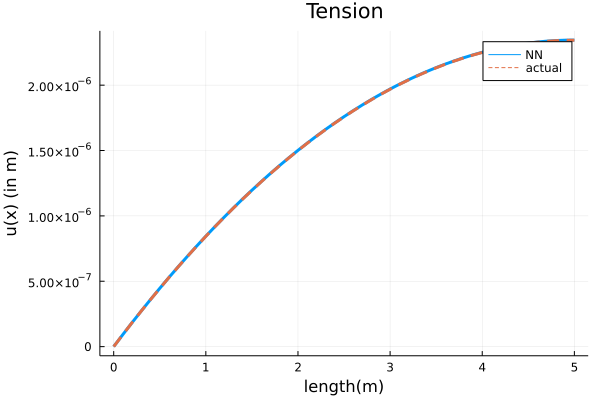

In [12]:
p = plot(dom,cons*δ.(dom),linewidth = 3, title = "Tension", label = "NN",xaxis="length(m)",yaxis="u(x) (in m)")
p = plot!(dom,analytic_solution_Tension.(dom),lw=3,ls=:dash,label = "actual")
savefig("variable_load_1d_bar.pdf")
plot(p)